# Imports

In [1]:
from pyiron_contrib.tinybase.job import GenericTinyJob

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [2]:
from pyiron_contrib.tinybase.executor import ProcessExecutor

In [3]:
from pyiron_contrib.tinybase.murn import MurnaghanTask

In [4]:
from pyiron_contrib.tinybase.ase import AseMDTask, AseMinimizeTask, AseStaticTask

In [5]:
from pyiron_contrib.tinybase.project import ProjectAdapter, InMemoryProject

In [6]:
from ase import Atoms

In [7]:
from ase.build import bulk

In [8]:
from ase.calculators.morse import MorsePotential

In [9]:
from pyiron_base import Project

In [29]:
import logging
logging.getLogger().setLevel(10)

# Create Project and a new Job


In [14]:
pr = ProjectAdapter(Project('tinyjob'))

## MD Job

In [15]:
j = GenericTinyJob(pr, 'md')

In [16]:
j.task_class = AseMDTask

In [17]:
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()

In [18]:
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20

In [19]:
j.run(how='foreground')

INFO:root:Job already finished!


In [20]:
j.output.animate_structures()

NGLWidget(max_frame=21)

## Min Job

In [21]:
j = GenericTinyJob(pr, 'min')

In [22]:
j.task_class = AseMinimizeTask

In [23]:
j.input.structure = Atoms(symbols=['Fe', 'Fe'], positions=[[0,0,0], [0,0, .75]], cell=[10,10,10])
j.input.structure.rattle(1e-3)
j.input.calculator = MorsePotential()

In [24]:
j.input.lbfgs(damping=.25)
j.input.max_steps = 100
j.input.output_steps = 10

In [25]:
exe = j.run(how='process')
if exe is not None:
    exe.wait()

INFO:root:Job already finished!


In [26]:
j.project.database.job_table()

id username  name  jobtype_id  project_id  status_id  \
0   4   pyiron    md           1           1          4   
1   5   pyiron   min           2           1          5   
2   6   pyiron  murn           3           1          6   

                                            location    status  \
0  /home/poul/pyiron/contrib/notebooks/tinybase/t...  finished   
1  /home/poul/pyiron/contrib/notebooks/tinybase/t...  finished   
2  /home/poul/pyiron/contrib/notebooks/tinybase/t...  finished   

              type  
0        AseMDTask  
1  AseMinimizeTask  
2    MurnaghanTask

In [27]:
j.output.animate_structures()

NGLWidget(max_frame=11)

Escape hatch to old HDF output.

### Loading from job id or name works

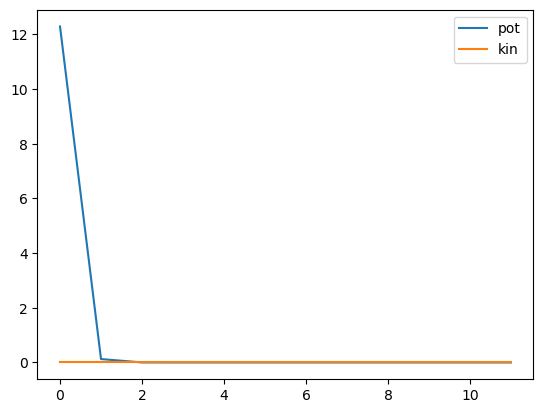

In [30]:
j.project.load(j.id).output.plot_energies()

In [31]:
j.project.load(j.name).output.animate_structures()

NGLWidget(max_frame=11)

## Murnaghan

In [41]:
murn = GenericTinyJob(pr, 'murn')

In [42]:
murn.task_class = MurnaghanTask

In [43]:
murn.input.task = AseStaticTask()
murn.input.task.input.calculator = MorsePotential()

In [44]:
murn.input.structure = bulk("Fe", a=1.2)

In [45]:
murn.input.set_strain_range(.5, 500)

In [46]:
murn.input.child_executor = ProcessExecutor

In [47]:
exe = murn.run()

DEBUG:h5py._conv:Creating converter from 5 to 3


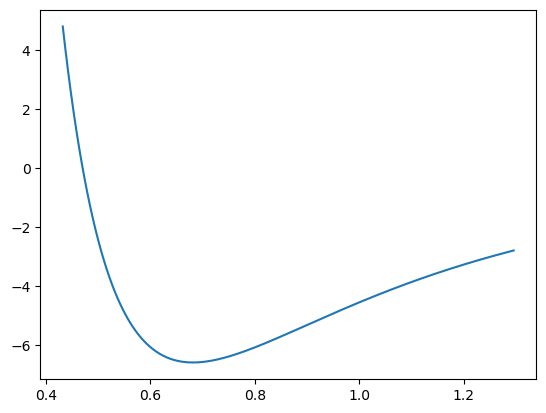

In [48]:
murn.output.plot()

# Pyiron purely in memory

Because the new ProjectInterface completely controls both the storage class and the database a job sees, we can easily swap them without changing anything in `TinyJob` at all.  As a demonstration we can make here a project that persists only for the duration of the process life time.  But it's not hard to imagine a number  of different project type depending on database configuration or storage location (S3, a single HDF5 for all jobs, etc.)

In [49]:
pr = InMemoryProject('/')

In [50]:
pr.job_table()

Empty DataFrame
Columns: []
Index: []

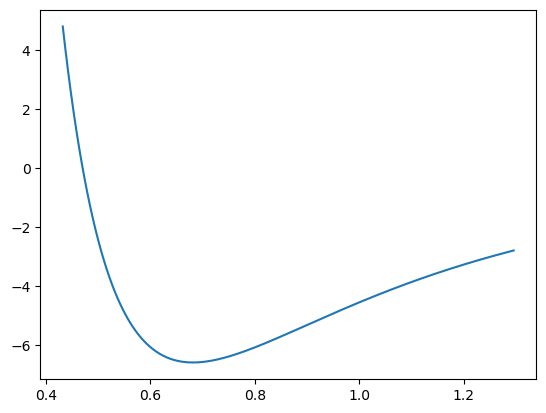

In [51]:
murn = GenericTinyJob(pr, 'murn')
murn.task_class = MurnaghanTask
murn.input.task = AseStaticTask()
murn.input.task.input.calculator = MorsePotential()
murn.input.structure = bulk("Fe", a=1.2)
murn.input.set_strain_range(.5, 500)
murn.input.child_executor = ProcessExecutor
murn.run()
murn.output.plot()

In [52]:
pr.job_table()

id username  name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron  murn           1           1          1        /  finished   

            type  
0  MurnaghanTask

In [54]:
j = GenericTinyJob(pr, 'md')
j.task_class = AseMDTask
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run(how='background')

In [55]:
pr.job_table()

id username  name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron  murn           1           1          1        /  finished   
1   2   pyiron    md           2           1          2        /   running   

            type  
0  MurnaghanTask  
1      AseMDTask

Subprojects work.

In [57]:
sub = pr.open_location("/foo")
j = GenericTinyJob(sub, 'md')
j.task_class = AseMDTask
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run(how='process')

In [58]:
pr.job_table()

id username  name  jobtype_id  project_id  status_id location    status  \
0   1   pyiron  murn           1           1          1        /  finished   
1   2   pyiron    md           2           1          2        /  finished   
2   3   pyiron    md           2           2          3     /foo   running   

            type  
0  MurnaghanTask  
1      AseMDTask  
2      AseMDTask

# Database Tests

In [59]:
db = j.project.database

In [60]:
db.get_item(1)

DatabaseEntry(name='murn', username='pyiron', project='/', status='finished', jobtype='MurnaghanTask')

In [61]:
eng = db.engine

In [62]:
from sqlalchemy.orm import Session

In [63]:
s = Session(eng)

In [64]:
from pyiron_contrib.tinybase.database import Job, Project as DProject, JobStatus, JobType

In [65]:
s.query(Job.id).where(Job.name == "min", ).all()

[]

In [66]:
s.query(JobStatus.__table__).select_from(Job).where(Job.id == 2, Job.status_id == JobStatus.id).all()

[(2, 'finished')]

In [67]:
s.query(JobStatus.__table__).all()

[(1, 'finished'), (2, 'finished'), (3, 'finished')]

In [68]:
s.query(DProject.__table__).all()

[(1, '/'), (2, '/foo')]

In [69]:
s.query(JobType.__table__).all()

[(1, 'MurnaghanTask'), (2, 'AseMDTask')]